<a href="https://colab.research.google.com/github/mansimar11/Asteroid_Spectra_ml_dl/blob/main/dl_autoencode_gmm_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

# Import installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Scikit-Learn stuff
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

# Keras
import tensorflow.keras as keras
import tensorflow as tf

# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/Colab/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""

# Load the level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())
asteroids_y_bus = np.array(asteroids_df["Bus_Class"].to_list())

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):

    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]
    y_train_bus, y_test_bus = asteroids_y_bus[train_index], asteroids_y_bus[test_index]

In [ ]:
from sklearn import preprocessing

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the training data to fit
# the scaler
scaler = preprocessing.StandardScaler().fit(X_train)

# Transform now the training data
X_train_scaled = scaler.transform(X_train)

# Scale the testing data ...
X_test_scaled = scaler.transform(X_test)

# And expanding the dimensionality for our ConvNet-based Autoencoder
X_train_scaled = np.expand_dims(X_train_scaled, axis=2)
X_test_scaled = np.expand_dims(X_test_scaled, axis=2)

In [ ]:
n_inputs = asteroids_X.shape[1]
# Let's create an autoencoder with a 2-D latent space
n_bottleneck = 5

def create_model():

    # Input layer, this time without a normalisation layer
    input_layer = keras.Input(shape=(n_inputs, 1))

    # Conv Layers (we won't be using maxpooling, since the dimensionaliy is 49 and we do not
    # alter the data in our example
    hidden_layer = keras.layers.Conv1D(filters=16,
                                       activation="relu",
                                       kernel_size=3, padding="same")(input_layer)
    hidden_layer = keras.layers.Conv1D(filters=32,
                                       activation="relu",
                                       kernel_size=3, padding="same")(hidden_layer)

    # Encoder ("Bottleneck" of the Autoencoder)
    bottleneck_lay = keras.layers.Flatten()(hidden_layer)
    bottleneck_lay = keras.layers.Dense(n_bottleneck)(bottleneck_lay)

    # The original shape must be restored and reshaped accordingly
    reset_lay = keras.layers.Dense(49*32)(bottleneck_lay)
    reshape_lay = keras.layers.Reshape((49, 32))(reset_lay)

    # First and second hidden decoder layers
    hidden_layer = keras.layers.Conv1DTranspose(filters=32,
                                                kernel_size=3,
                                                strides=1,
                                                activation="relu",
                                                padding="same")(reshape_lay)
    hidden_layer = keras.layers.Conv1DTranspose(filters=16,
                                                kernel_size=3,
                                                strides=1,
                                                activation="relu",
                                                padding="same")(hidden_layer)

    # Ouput layer (same size as input layer)
    output_layer = keras.layers.Conv1D(1, 1, padding="same")(hidden_layer)

    # Create model
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    # Create encoder model
    encoder_model = keras.models.Model(inputs=input_layer, outputs=bottleneck_lay)

    # We return the model and the encoder
    return model, encoder_model

model, encoder_model = create_model()

# Compile the model and use a regression loss function
model.compile(optimizer='adam', loss='mse')

# Show the model summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 49, 1)]           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 49, 16)            64        
                                                                 
 conv1d_4 (Conv1D)           (None, 49, 32)            1568      
                                                                 
 flatten_1 (Flatten)         (None, 1568)              0         
                                                                 
 dense_2 (Dense)             (None, 5)                 7845      
                                                                 
 dense_3 (Dense)             (None, 1568)              9408      
                                                                 
 reshape_1 (Reshape)         (None, 49, 32)            0   

In [ ]:
end_epoch = 500
batch_size = 32

# Early Stopping for our final model
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train_scaled, X_train_scaled,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=0,
                    validation_split=0.25,
                    callbacks=[es_callback])

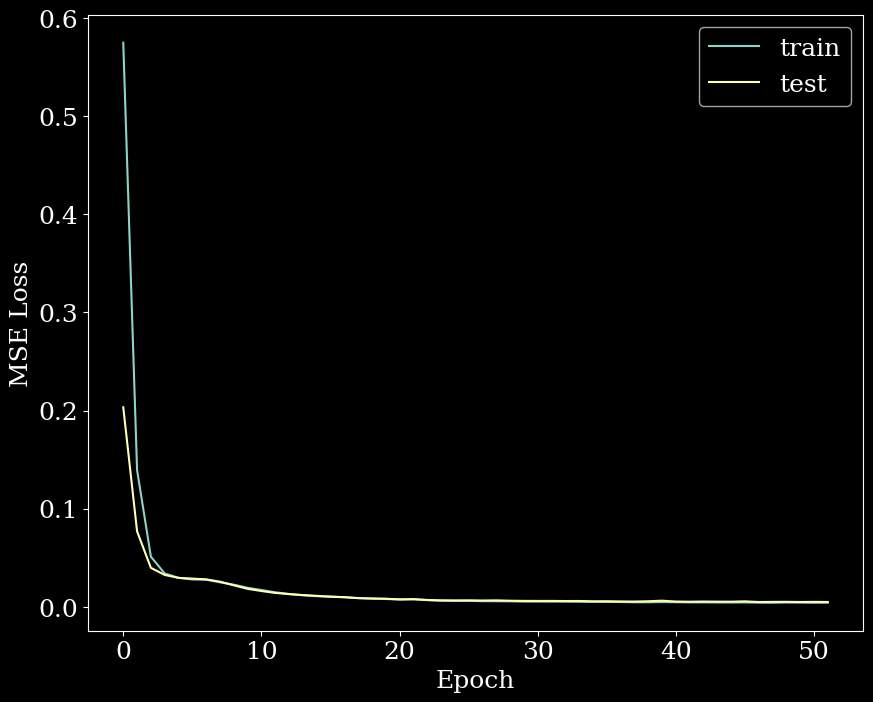

In [ ]:
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

# plot the training and validation loss
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

# Add legend and labels
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

# ... aaaaand plot!
plt.show()

34/34 [==============================] - 0s 3ms/step


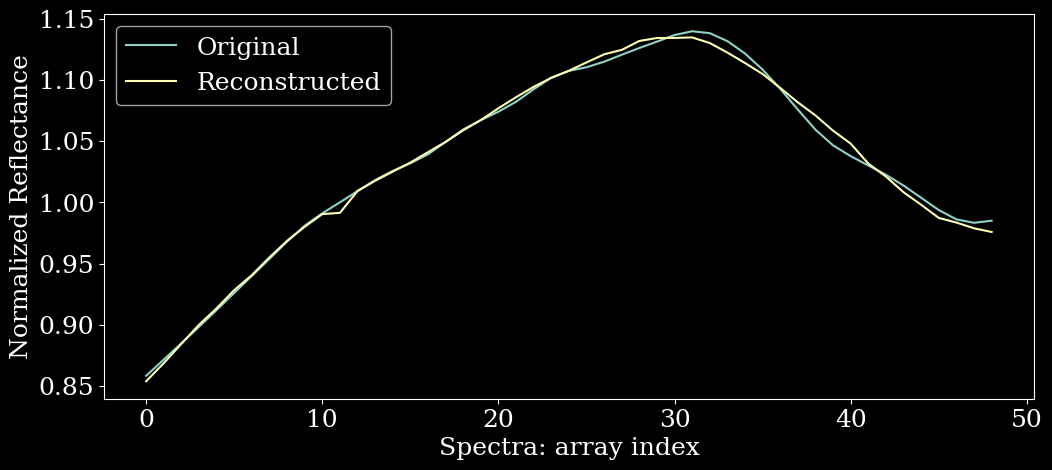

In [ ]:
index_val = 5

# Original signal
org_signal = scaler.inverse_transform(X_train_scaled[index_val].reshape(1, -1))[0]
# Reconstructed signal
rec_signal = scaler.inverse_transform(model.predict(X_train_scaled)[index_val].reshape(1, -1))[0]

# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

# plot the training and reconstructed data
plt.figure(figsize=(12,5))
plt.plot(org_signal, label='Original')
plt.plot(rec_signal, label='Reconstructed')

# Add legend and labels
plt.legend()
plt.xlabel("Spectra: array index")
plt.ylabel("Normalized Reflectance")

# ... aaaaand plot!
plt.show()

In [ ]:
X_train_encoded = encoder_model.predict(X_train_scaled)
X_test_encoded = encoder_model.predict(X_test_scaled)

# Merge the data
X_encoded = np.vstack((X_train_encoded, X_test_encoded))

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the encoded data to fit
# the scaler
enc_scaler = preprocessing.StandardScaler().fit(X_encoded)

# Transform now the encoded data (later used for our scikit-learn method)
X_encoded_scaled = enc_scaler.transform(X_encoded)

# Merge the classes
y_main = np.hstack((y_train, y_test))
y_bus = np.hstack((y_train_bus, y_test_bus))

# Create a column names array for the encoded space
encoder_space = [f"enc{enc_nr+1}" for enc_nr in range(n_bottleneck)]
encoder_space_cols = encoder_space.copy()
encoder_space.extend(["Main_Group", "Bus_Class"])

# Create the dataframe
encoded_df = pd.DataFrame(np.hstack((X_encoded_scaled,
                                     y_main[np.newaxis].transpose(),
                                     y_bus[np.newaxis].transpose())),
                          columns=encoder_space)

# Change the dtype to float
encoded_df.loc[:, encoder_space[:-2]] = encoded_df.loc[:, encoder_space[:-2]].astype(float)

9/9 [==============================] - 0s 2ms/step


In [ ]:
import sklearn.mixture
import tqdm

# Result dataframe that will contain the number of Gaussian components, the Bayesion Information
# Criterion (BIC) and the model itself
gmm_results_df = pd.DataFrame([], columns=["Nr_Comp", "BIC", "Model"])

# We iterate through a number of "component guesses"
max_gauss = 15
for index, gauss_components in tqdm.tqdm(enumerate(np.arange(1, max_gauss+1, 1))):

    # Create and fit a temporary Gaussian Mixture Model
    temp_gmm = sklearn.mixture.GaussianMixture(n_components=gauss_components,
                                               covariance_type="full")
    temp_gmm.fit(X_encoded_scaled)

    # Store the number of components, the BIC and the model
    gmm_results_df.loc[index, "Nr_Comp"] = gauss_components
    gmm_results_df.loc[index, "BIC"] = temp_gmm.bic(X_encoded_scaled)
    gmm_results_df.loc[index, "Model"] = temp_gmm

15it [00:02,  5.70it/s]


(1.0, 15.0)

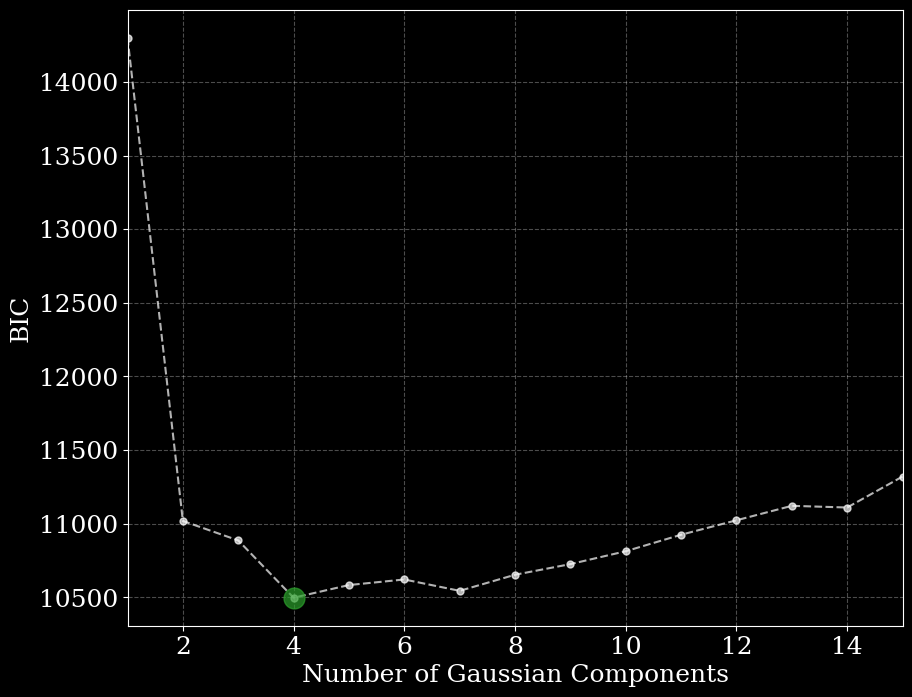

In [ ]:
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

# Plotting the BIC vs. the number of components
plt.figure(figsize=(10, 8))

plt.plot(gmm_results_df["Nr_Comp"],
         gmm_results_df["BIC"],
         linestyle="dashed",
         marker="o",
         markersize=5,
         color="w",
         alpha=0.7)

# Color the minimum value
gmm_results_best = gmm_results_df.loc[gmm_results_df["BIC"] == gmm_results_df["BIC"].min()]
plt.plot(gmm_results_best["Nr_Comp"],
         gmm_results_best["BIC"],
         marker="o",
         markersize=15,
         color="tab:green",
         alpha=0.7)

# Some formatting
plt.xlabel("Number of Gaussian Components")
plt.ylabel("BIC")
plt.grid(linestyle="dashed", alpha=0.3)
plt.xlim(1, max_gauss)

In [ ]:
best_gmm = gmm_results_best["Model"].iloc[0]

# Create a new dataframe column that labels the spectra based on our GMM model:
encoded_df.loc[:, "GMM_Class"] = best_gmm.predict(encoded_df[encoder_space_cols].values)

encoded_df

,enc1,enc2,enc3,enc4,enc5,Main_Group,Bus_Class,GMM_Class
0,-1.231085,-0.949437,1.204573,1.893793,1.723165,C,B,1
1,0.884536,-0.098914,-0.507565,-1.063504,-0.395796,S,S,0
2,-1.477347,-0.883587,1.105139,0.394299,1.033406,C,Ch,1
3,-1.072668,-0.821879,1.002312,-0.201715,0.954742,C,C,1
4,1.788875,-1.728998,0.26495,-1.164892,0.867479,Other,V,3
...,...,...,...,...,...,...,...,...
1334,0.475564,-0.272595,-1.791784,0.744683,-1.222766,S,Sl,3
1335,-1.301743,-1.109721,1.17153,0.23338,1.008693,C,Ch,1
1336,-0.735902,0.255767,0.63412,-0.356603,0.759449,X,Xe,2
1337,-0.575441,-0.416355,1.027076,1.911429,1.265255,C,Cb,1


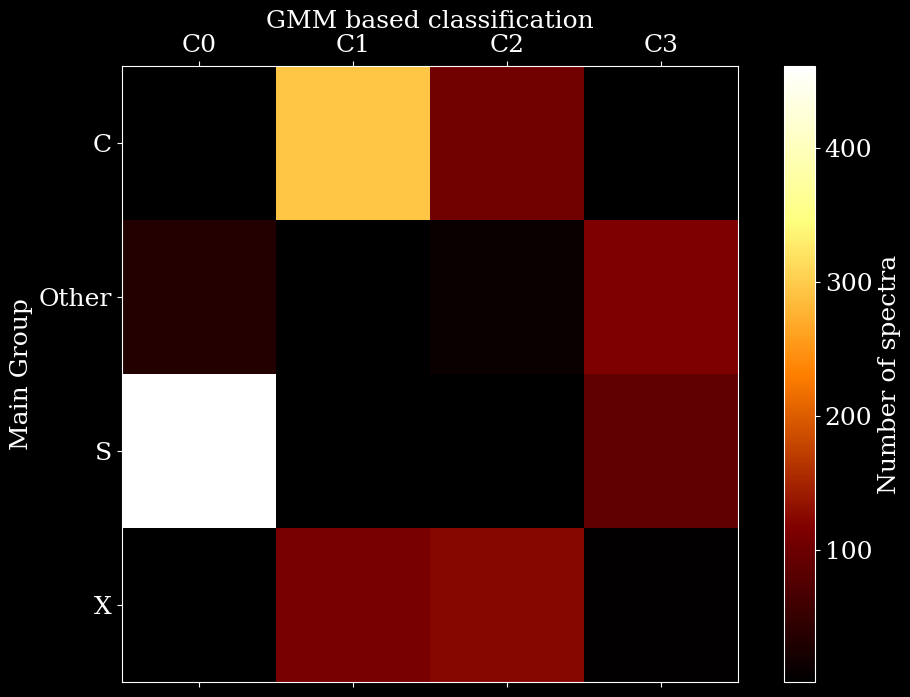

In [ ]:
encoded_grouped_df = pd.crosstab(index=encoded_df["Main_Group"],
                                 columns=encoded_df["GMM_Class"],
                                 values=encoded_df["enc1"],
                                 aggfunc="count")

# Extract data, column and index names for plotting purposes
encoded_grouped_values = encoded_grouped_df.values
encoded_grouped_main = encoded_grouped_df.index.values
encoded_grouped_gmm = [f"C{k}" for k in encoded_grouped_df.columns.values]


# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

# Create a matrix-like plot of the results
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
cax = ax.matshow(encoded_grouped_values, cmap="afmhot")
fig.colorbar(cax, label="Number of spectra", fraction=0.05)

# Some plotting settings
ax.set_xticks(range(len(encoded_grouped_gmm)))
ax.set_yticks(range(len(encoded_grouped_main)))
ax.set_xticklabels(encoded_grouped_gmm)
ax.set_yticklabels(encoded_grouped_main)

ax.set_xlabel("GMM based classification")
ax.set_ylabel("Main Group")
ax.xaxis.set_label_position('top')

In [ ]:
encoded_main_s_df = encoded_df.loc[encoded_df["Main_Group"] == "S"].copy()

encoded_main_s_df.groupby("GMM_Class").count()

,enc1,enc2,enc3,enc4,enc5,Main_Group,Bus_Class
GMM_Class,,,,,,,
0,461,461,461,461,461,461,461
3,88,88,88,88,88,88,88


In [ ]:
encoded_grouped_gmm_prob = [f"C{k}Prob" for k in encoded_grouped_df.columns.values]

encoded_main_s_df.loc[:, encoded_grouped_gmm_prob] = \
    best_gmm.predict_proba(encoded_main_s_df[encoder_space_cols].values)

encoded_main_s_df

,enc1,enc2,enc3,enc4,enc5,Main_Group,Bus_Class,GMM_Class,C0Prob,C1Prob,C2Prob,C3Prob
1,0.884536,-0.098914,-0.507565,-1.063504,-0.395796,S,S,0,0.980914,5.660924e-37,4.609789e-13,0.019086
5,0.431795,0.134821,0.070236,-1.171216,0.232223,S,Sk,0,0.985570,7.618397e-12,1.242215e-05,0.014417
7,0.899469,0.395109,-0.992049,-0.82842,-0.902508,S,S,0,0.984766,1.213896e-54,1.037236e-16,0.015234
8,0.927925,-0.347403,0.020861,-0.658563,-0.211005,S,Sq,0,0.951481,4.626712e-24,4.038953e-08,0.048519
11,0.361886,0.410641,-0.508409,-0.102261,-0.496778,S,S,0,0.977970,4.753738e-28,3.712946e-08,0.022030
...,...,...,...,...,...,...,...,...,...,...,...,...
1325,0.655966,0.399775,-1.312052,-0.181437,-1.097519,S,S,0,0.957290,4.520855e-84,2.171996e-22,0.042710
1327,1.461959,-0.215542,-0.801242,-0.238408,-1.145085,S,S,0,0.819331,6.642266e-77,1.627704e-20,0.180669
1331,0.817463,0.239067,-0.958228,-0.101511,-1.322973,S,S,0,0.949513,2.816142e-72,1.472485e-17,0.050487
1332,0.719894,0.264425,-0.626381,-0.36555,-0.196945,S,S,0,0.968427,1.925654e-33,7.594684e-12,0.031573


Text(0, 0.5, 'Number of spectra')

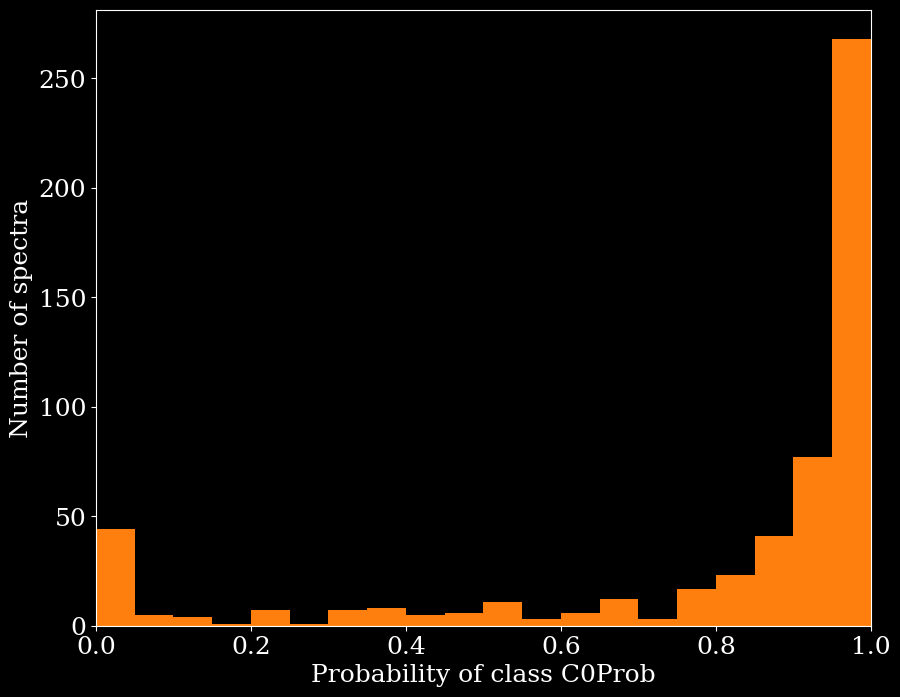

In [ ]:
gmm_cl = "C0Prob"

# Let's plot the probability distribution
plt.figure(figsize=(10, 8))

plt.hist(encoded_main_s_df[gmm_cl], bins=np.arange(0, 1.1, 0.05), color="tab:orange")

plt.xlim(0, 1)

plt.xlabel(f"Probability of class {gmm_cl}")
plt.ylabel("Number of spectra")

In [ ]:
encoded_main_s_df = encoded_main_s_df.loc[encoded_main_s_df[gmm_cl] >= 0.95]

encoded_main_s_df

,enc1,enc2,enc3,enc4,enc5,Main_Group,Bus_Class,GMM_Class,C0Prob,C1Prob,C2Prob,C3Prob
1,0.884536,-0.098914,-0.507565,-1.063504,-0.395796,S,S,0,0.980914,5.660924e-37,4.609789e-13,0.019086
5,0.431795,0.134821,0.070236,-1.171216,0.232223,S,Sk,0,0.985570,7.618397e-12,1.242215e-05,0.014417
7,0.899469,0.395109,-0.992049,-0.82842,-0.902508,S,S,0,0.984766,1.213896e-54,1.037236e-16,0.015234
8,0.927925,-0.347403,0.020861,-0.658563,-0.211005,S,Sq,0,0.951481,4.626712e-24,4.038953e-08,0.048519
11,0.361886,0.410641,-0.508409,-0.102261,-0.496778,S,S,0,0.977970,4.753738e-28,3.712946e-08,0.022030
...,...,...,...,...,...,...,...,...,...,...,...,...
1305,0.363126,0.004808,0.423537,-1.324618,0.344144,S,Sq,0,0.975225,1.256985e-09,7.127414e-04,0.024062
1307,0.225962,1.181739,-0.847903,-0.359161,-0.514115,S,S,0,0.955356,8.444800e-24,1.593061e-07,0.044644
1310,0.871873,0.196559,-0.703733,-0.468649,-0.625685,S,S,0,0.986525,6.041869e-44,6.323964e-14,0.013475
1325,0.655966,0.399775,-1.312052,-0.181437,-1.097519,S,S,0,0.957290,4.520855e-84,2.171996e-22,0.042710


In [ ]:
!pip install pingouin
import pingouin

In [ ]:
encoded_main_s = np.array(encoded_main_s_df[encoder_space_cols].values, dtype="float64")
pingouin.multivariate_normality(encoded_main_s)

HZResults(hz=1.1384486230433217, pval=0.00043426727158130406, normal=False)